## 1. Create a Image Hash.

### Idea from https://github.com/mendesk/image-ndd-lsh

In [87]:
!python3 -m pip install imagehash Image

In [88]:
import imagehash
from PIL import Image
import numpy as np

Article -> https://pypi.org/project/ImageHash/
dhash -> difference hash

In [89]:
def calculate_signature(image_file: str, hash_size: int) -> np.ndarray:
    pil_image = Image.open(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

In [90]:
def calculate_signature_np(image_file: np.array, hash_size: int) -> np.ndarray:
    pil_image = Image.fromarray(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.BILINEAR)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

## 2. Create LSH algorithm

### 2.1 Get the dataset

In [91]:
#!apt-get install wget
#!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [92]:
#!tar -xvzf cifar-10-python.tar.gz

In [93]:
#!rm -rf cifar-10-python.tar.gz
#!mv cifar-10-batches-py ../data

### 2.2 Read the files

In [94]:
import os
import _pickle as cPickle

In [95]:
PATH = "../data/cifar-10-batches-py/"

#### 2.2.1 Load Cifar-10

In [96]:
def load_batch():
    file = 'data_batch_1'

    f = open(PATH+file, 'rb')
    dict = cPickle.load(f, encoding='latin1')
    images = dict['data']
    #images = np.reshape(images, (10000, 3, 32, 32))
    labels = dict['labels']
    imagearray = np.array(images)   #   (10000, 3072)
    labelarray = np.array(labels)   #   (10000,)
    
    return imagearray, labelarray

In [97]:
def load_classes():
    file = 'batches.meta'
    
    f = open(PATH+file, 'rb')
    dict = cPickle.load(f)
    return dict['label_names']

def print_classes(label_names):
    for i in range(0, 10):
        print(str(i) + " : " + label_names[i] + "  ")

label_names = load_classes()
print_classes(label_names)

0 : airplane  
1 : automobile  
2 : bird  
3 : cat  
4 : deer  
5 : dog  
6 : frog  
7 : horse  
8 : ship  
9 : truck  


In [98]:
images, labels = load_batch()

In [99]:
labels.shape

(10000,)

In [100]:
image = np.reshape(images[0], (3, 32, 32))

In [101]:
image.shape

(3, 32, 32)

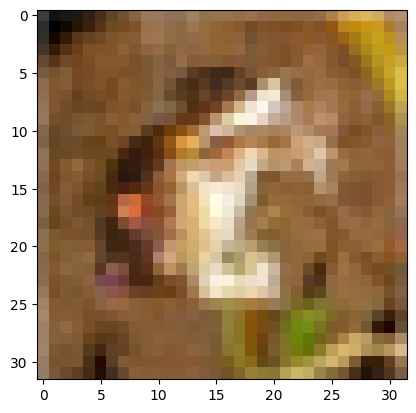

In [102]:
from matplotlib import pyplot as plt
plt.imshow(image.T, interpolation='nearest')
plt.show()

In [103]:
print(label_names[labels[0]])

frog


In [104]:
calculate_signature_np(image.T, 8)

array([ True,  True,  True, False, False,  True,  True,  True,  True,
        True, False, False,  True, False, False,  True, False, False,
        True,  True,  True, False, False, False, False, False,  True,
        True, False, False, False, False, False,  True,  True,  True,
       False, False, False,  True, False, False,  True,  True, False,
       False, False, False, False, False,  True,  True, False, False,
        True, False, False,  True,  True,  True, False,  True, False,
       False])

### 2.2.2 Algorithm

In [108]:
from typing import List, Dict, Tuple

class LSH:
    def __init__(self, size, hash_size):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = dict()
        self.hash_size = hash_size

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)
    
    def compute_hash(self, images):
        idx = 0;
        for image in images:
            signature = calculate_signature_np(image.T, self.hash_size)
            # Keep track of each image's signature
            self.signatures[idx] = np.packbits(signature)
            self.fill_buckets(signature, idx)
            idx+=1

    def compute_candidate(self):
        candidate_pairs = set()
        
        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket) # Why needed ?
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                                tuple([hash_bucket[i],hash_bucket[j]])
                            )
        return candidate_pairs

    def check_candidate(self, candidate_pairs, threshold=0.9):
        
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            hd = sum(np.bitwise_xor(
                    np.unpackbits(self.signatures[cpa]), 
                    np.unpackbits(self.signatures[cpb])
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates
            
    

In [109]:
images = images.reshape(10000,3,32,32)
images.shape

(10000, 3, 32, 32)

In [115]:
import time

start = time.time()

lsh = LSH(16, 16)
lsh.compute_hash(images)
pairs = lsh.compute_candidate()
#duplicates = lsh.check_candidate(pairs,0.9)

end = time.time()
print( "time: ", end - start )

time:  1.1364402770996094


In [111]:
len(pairs)

2466583

In [60]:
len(duplicates)

1692

In [68]:
duplicates

[(2065, 4828, 1.0),
 (8975, 9432, 1.0),
 (3789, 5416, 1.0),
 (2379, 7841, 1.0),
 (4875, 9275, 1.0),
 (4828, 6717, 1.0),
 (1775, 6495, 1.0),
 (2065, 6717, 1.0),
 (8443, 8588, 0.984375),
 (8443, 9522, 0.984375),
 (8168, 8429, 0.984375),
 (84, 8357, 0.984375),
 (3789, 5657, 0.984375),
 (6543, 9786, 0.984375),
 (661, 2210, 0.984375),
 (7841, 8384, 0.984375),
 (2464, 5765, 0.984375),
 (2192, 4828, 0.984375),
 (2192, 6717, 0.984375),
 (5416, 5657, 0.984375),
 (1687, 1978, 0.984375),
 (2379, 8384, 0.984375),
 (2065, 2192, 0.984375),
 (3789, 5644, 0.96875),
 (1726, 8443, 0.96875),
 (1648, 2065, 0.96875),
 (8471, 9708, 0.96875),
 (558, 1060, 0.96875),
 (139, 9708, 0.96875),
 (1229, 6717, 0.96875),
 (5530, 8443, 0.96875),
 (330, 3294, 0.96875),
 (1229, 4828, 0.96875),
 (3250, 6717, 0.96875),
 (6717, 8005, 0.96875),
 (1711, 8443, 0.96875),
 (3789, 6543, 0.96875),
 (3250, 7995, 0.96875),
 (4828, 7995, 0.96875),
 (2578, 3140, 0.96875),
 (8588, 9522, 0.96875),
 (3250, 4828, 0.96875),
 (4277, 6370, 0

In [78]:
print(lsh.signatures)

{0: array([231, 201,  56,  48, 113,  48,  50, 116], dtype=uint8), 1: array([ 51,  50,  50,  48,  48, 240, 241, 121], dtype=uint8), 2: array([129, 131,   3,  67,  35,  23,   7,   3], dtype=uint8), 3: array([185, 217, 217, 249, 241, 243, 249, 115], dtype=uint8), 4: array([17, 25, 25, 25, 25, 24, 25,  9], dtype=uint8), 5: array([199, 207, 192, 192,  32, 192, 193, 230], dtype=uint8), 6: array([ 24,  25,   7,  35,   7,  37, 101, 116], dtype=uint8), 7: array([248, 120, 124,  13, 141, 140,  29, 157], dtype=uint8), 8: array([15, 13, 15, 47, 43, 27, 19, 16], dtype=uint8), 9: array([ 37,  25, 153, 131, 203, 199,  67,  79], dtype=uint8), 10: array([203, 231, 148, 222, 198, 199, 230, 230], dtype=uint8), 11: array([ 71,  71, 203, 143, 134, 134, 199,  70], dtype=uint8), 12: array([130, 138,  26, 135, 135, 135, 135,   7], dtype=uint8), 13: array([247, 179, 247, 247, 247, 230, 182, 214], dtype=uint8), 14: array([ 51,  99, 195, 134, 154,  26,  90,  82], dtype=uint8), 15: array([249, 232, 200,   8,   9,

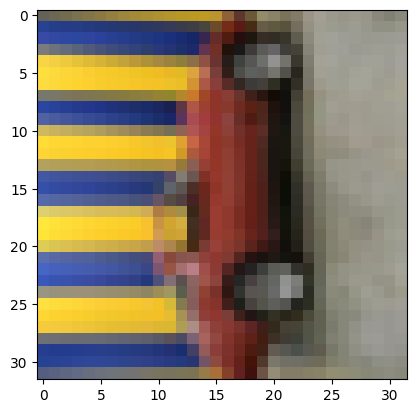

In [75]:
plt.imshow(images[330].reshape(3,32,32).T, interpolation='nearest')
plt.show()

In [65]:
labels[2065]

8

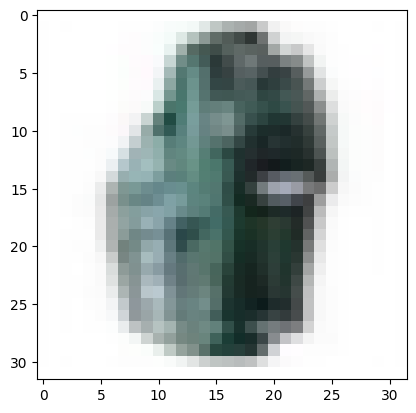

In [76]:
plt.imshow(images[6495].reshape(3,32,32).T, interpolation='nearest')
plt.show()

In [66]:
labels[4828]

8

dhash is a Python library that generates a "difference hash" for a given image -- 
a perceptual hash based on Neal Krawetz's dHash algorithm in this "Hacker Factor" blog entry.

I've found that dhash is great for detecting near duplicates (we found dupes using a size 8 dhash with a maximum delta of 2 bits). But because of the simplicity of the algorithm, it's not great at finding similar images or duplicate-but-cropped images -- you'd need a more sophisticated image fingerprint if you want that. However, the dhash is good for finding exact duplicates and near duplicates, for example, the same image with slightly altered lighting, a few pixels of cropping, or very light photoshopping.

The library defaults to producing a size 8 dhash, but you can override this easily by passing size=N as a keyword argument to most functions. For example, you can produce a more accurate (but slower to work with) dhash of 512 bits by specifying size=16.
